In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_precision_recall_curve, recall_score, precision_recall_curve, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
import string

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\geada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('labeled.csv')

# Анализ данных

In [5]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [6]:
df.shape

(14412, 2)

In [10]:
df.toxic = df.toxic.apply(int)  # переведем колонку toxic в целые числа

In [11]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [12]:
df.toxic.value_counts()  # распределение токсичных и нетоксичных комментариев

0    9586
1    4826
Name: toxic, dtype: int64

#### Выведем токсичные комментарии

In [13]:
for com in df[df.toxic == 1].comment.head():
    print(com)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



#### Выведем нетоксичные комментарии

In [14]:
for com in df[df.toxic == 0].comment.head():
    print(com)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

###### При выводе нетоксичных комментариев можно заметить, что первые 4 комментария подходят под понятние "нетоксичный комментарий", в то время как последний комментарий получился довольно негативным.

#### Создадим тестовый датасет

In [15]:
train_df, test_df = train_test_split(df, test_size=500)

In [16]:
test_df.shape

(500, 2)

In [17]:
test_df.toxic.value_counts()  # проверим распределение

0    330
1    170
Name: toxic, dtype: int64

In [18]:
train_df.toxic.value_counts()

0    9256
1    4656
Name: toxic, dtype: int64

# Предобработка текста

Мы будем использовать логистическую регрессию, но перед тем как подавать данные на вход логистической регрессии нужно из текста сделать численные векторы, так как сама модель принимает на вход вещественные векторы. Для этого нужно провести несколько этапов предобработки текста:
- Разобить текст на токены
- Удалить те токены, которые не несут смысловой информации(знаки пунктуации, популярные слова в языке)
- Каждому токену применить стемминг
- Создание векторов

In [21]:
sentence_example = df.iloc[1].comment  # берем пример
tokens = word_tokenize(sentence_example, language='russian')
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]  # удаляем знаки пунктуации
russian_stop_words = stopwords.words('russian')
tokens_without_punctuation_and_stop_words = [i for i in tokens_without_punctuation if i not in russian_stop_words] # удалем популярные слова
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_punctuation_and_stop_words]  # стемминг

###### Выведем, что получилось

In [22]:
print(f"Исходый текст: {sentence_example}")
print("---------------------------------")
print(f"Токены: {tokens}")
print("---------------------------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("---------------------------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_punctuation_and_stop_words}")
print("---------------------------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("---------------------------------")

Исходый текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

---------------------------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
---------------------------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
---------------------------------
Токены без пунктуации и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
---------------------------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
---

##### Функция, чтобы можно было применять эту предобработку для каждого комментария 

In [24]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    """
    remove_stop_words: True, если нужно удалять стоп слова, иначе False
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [25]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [42]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [43]:
features = vectorizer.fit_transform(train_df.comment)

# Тренировка моделей

In [44]:
model = LogisticRegression(random_state=23)
model.fit(features, train_df.toxic)

LogisticRegression(random_state=23)

In [49]:
model.predict(features[7])

array([0], dtype=int64)

In [50]:
train_df.comment.iloc[7]

'У нас такой на работе стоит, хз кому продать\n'

###### Так пользоваться моделью неудобно, лучше подавать на вход текст.  pipeline

In [51]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=23))
])

In [52]:
model_pipeline.fit(train_df.comment, train_df.toxic)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000024E49B9DD30>)),
                ('model', LogisticRegression(random_state=23))])

In [59]:
model_pipeline.predict(["Привет! У меня все нормально, как у тебя дела?"])

array([0], dtype=int64)

In [60]:
model_pipeline.predict(["слушай не пойти ли бы тебе... "])

array([1], dtype=int64)

### Метрики

In [61]:
precision_score(y_true=test_df.toxic, y_pred=model_pipeline.predict(test_df.comment))

0.9363636363636364

In [62]:
recall_score(y_true=test_df.toxic, y_pred=model_pipeline.predict(test_df.comment))

0.6058823529411764

Нужна модель с *precision_score* минимум 0.95, так что такая модель не подходит. Логистическая регрессия возвращает не просто значение(к какому классу это относится), а вероятности. Потом функция ***predict*** сравнивает это с каким-то порогом и если вероятность больше порога, то возвращается класс 1, иначе класс 0. Двигая этот порог модно менять *precision_score* и *recall_score*

In [63]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

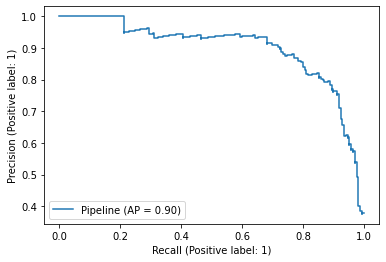

In [64]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df.comment, y=test_df.toxic)

In [65]:
np.where(prec > 0.95)

(array([399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 414,
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427,
        428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
        441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451], dtype=int64),)

In [66]:
thresholds[399]

0.724724046140298

In [67]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[399])

0.9607843137254902

In [68]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[374])

0.4176470588235294

### Улучшим модель

In [82]:
grid_pipeline = GridSearchCV(
        LogisticRegression(random_state=23),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )

In [92]:
grid_pipeline.fit(features, train_df.toxic)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ..........................................C=0.1; total time=   0.0s
[CV 2/3] END ..........................................C=0.1; total time=   0.0s
[CV 3/3] END ..........................................C=0.1; total time=   0.0s
[CV 1/3] END ............................................C=1; total time=   0.1s
[CV 2/3] END ............................................C=1; total time=   0.4s
[CV 3/3] END ............................................C=1; total time=   0.1s
[CV 1/3] END .........................................C=10.0; total time=   0.4s
[CV 2/3] END .........................................C=10.0; total time=   0.3s
[CV 3/3] END .........................................C=10.0; total time=   0.4s


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=23),
             param_grid={'C': [0.1, 1, 10.0]}, verbose=4)

In [84]:
grid_pipeline.best_params_

{'C': 10.0}

In [85]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(C=10., random_state=23))
])

In [93]:
model_pipeline_c_10.fit(train_df.comment, train_df.toxic)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000024E49E0F160>)),
                ('model', LogisticRegression(C=10.0, random_state=23))])

In [87]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [88]:
np.where(prec_c_10 > 0.95)

(array([369, 370, 371, 372, 373, 374, 375, 392, 393, 394, 395, 407, 408,
        409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
        422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434,
        435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
        448, 449, 450, 451, 452, 453, 454, 455, 456], dtype=int64),)

In [89]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[369])

0.9534883720930233

In [90]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[369])

0.4823529411764706

##### Получилась отличная модель